<hr style="border-width:2px;border-color:#75DFC1">
<center><h1>DLMI Kaggle challenge</h1></center>
<center><h2>Cleaning of the labels of the training set</h2></center>
<hr style="border-width:2px;border-color:#75DFC1">


The challenge instructions state that the labels are not perfect, so the idea of this notebook is to create a pipeline to clean them.

The general idea is to separate the training set into 5 folds, and for each of these folds, predict the isup grades thanks to a model trained on the 4 other folds. <br>
Then, if the label and the prediction are "too far" from one another, the label will be considered incorrect. <br>
We chose a regression model to have some flexibility on the threshold to be used to determine incorrect labels.
> To illustrate, let's say we set a threshold at 1.7
>> - If a label 2 is predicted at 2.8, we keep it $(2.8-2=0.8<1.7)$
>>
>>
>> - If a label 4 is predicted at 1.3, we do not keep it $(4-1.3=2.7>1.7)$

> The structure of this notebook is as follows: 
>> I - [Import of libraries and raw dataset](#imports)
>>
>>
>> II - [Creation and visualization of the pytorch dataset](#preparation)
>>
>>
>> III - [Model training](#train)
>>
>>
>> IV - [Out of fold prediction](#predi)

# I - <a name="imports"></a> Import of libraries and raw dataset

We start by installing and importing the libraries that we will need throughout the notebook.

In [ ]:
! pip install -q imagecodecs
! pip install -q warmup_scheduler
! pip install -q efficientnet_pytorch

In [ ]:
from google.colab import drive 
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import warnings
warnings.filterwarnings("ignore")

# Basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pylab import rcParams
from tqdm import tqdm
tqdm.pandas()

# Deep learning model
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler, RandomSampler, SequentialSampler
from warmup_scheduler import GradualWarmupScheduler
from efficientnet_pytorch import model as enet
import albumentations
from sklearn.model_selection import StratifiedKFold

Then we import the training data (the train dataframe to which we added the tiles during the preprocessing step - each slide is 100 tiles of size (128, 128, 3)).
> Note that by exporting the tiles, the arrays have been transformed into strings. We must therefore convert them back (this is the purpose of the *progress_apply*).

In [ ]:
# Import the dataframe
df = pd.read_csv("drive/MyDrive/DLMI/train_with_tiles.csv")
# Convert the tiles back into an array
df["tiles"] = df["tiles"].progress_apply(lambda x : np.array(x.replace("[", "").replace("]", "").split(",")).astype(np.int16).reshape(100, 128, 128, 3))

100%|██████████| 340/340 [14:59<00:00,  2.65s/it]


# II - <a name="preparation"></a> Creation and visualization of the pytorch dataset

The data is much too heavy to use all at once. So we will use pytorch generators, and take advantage of this to apply data augmentation both at the level of whole slides and at the level of tiles.

In [ ]:
class PANDADataset(Dataset):
    """Transforms the training dataframe into a pytorch dataset, and applies the data augmentation given as input."""

    def __init__(self, df, image_size=128, n_tiles=100, transform=None):
        self.df = df.reset_index(drop=True)
        self.image_size = image_size
        self.n_tiles = n_tiles
        self.transform = transform

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index, image_size=128):
        row = self.df.iloc[index]
        tiles = row.tiles
        n_row_tiles = int(np.sqrt(self.n_tiles))
        images = np.zeros((image_size * n_row_tiles, image_size * n_row_tiles, 3))
        for h in range(n_row_tiles):
            for w in range(n_row_tiles):
                i = h * n_row_tiles + w
                if len(tiles) > i:
                    this_img = tiles[i]
                else:
                    this_img = np.zeros((self.image_size, self.image_size, 3)).astype(np.uint8)
                this_img = 255 - this_img
                # Application of the augmentation on the tile level
                if self.transform is not None:
                    this_img = self.transform(image=this_img)['image']
                h1 = h * image_size
                w1 = w * image_size
                images[h1:h1+image_size, w1:w1+image_size] = this_img
        # Application of the augmentation on the whole slide level
        if self.transform is not None:
            images = self.transform(image=images)['image']
        images = images.astype(np.float32)
        images /= 255
        images = images.transpose(2, 0, 1)
        label = row.isup_grade
        # The function returns the image and the label of the image
        return torch.tensor(images), torch.tensor(label)

For the training set, a fairly basic augmentation is applied. For the validation set, no augmentation is applied.

In [ ]:
transforms_train = albumentations.Compose([albumentations.HorizontalFlip(p=0.5),
                                           albumentations.VerticalFlip(p=0.5),
                                           albumentations.Transpose(p=0.5)])

transforms_val = albumentations.Compose([])

Let's plot 10 random slides to see the results.

In [ ]:
dataset_show = PANDADataset(df, transform=transforms_train)

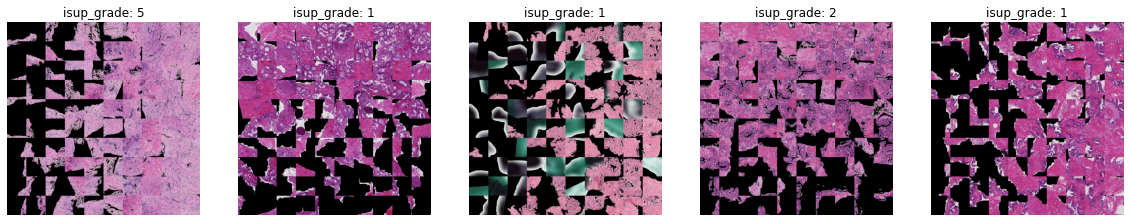

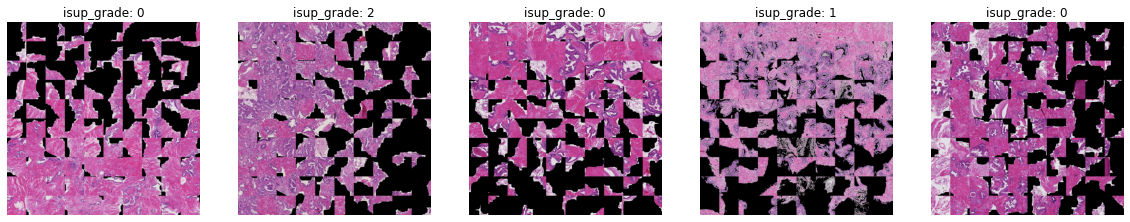

In [ ]:
rcParams["figure.figsize"] = 20, 10
for i in range(2):
    f, axarr = plt.subplots(1, 5)
    for p in range(5):
        idx = np.random.randint(0, len(dataset_show))
        img, label = dataset_show[idx]
        axarr[p].imshow(1. - img.transpose(0, 1).transpose(1,2).squeeze())
        axarr[p].set_title("isup_grade: "+str(label.numpy()))
        axarr[p].axis("off")

# III - <a name="train"></a> Model training

In this part, we split the training data into 5 folds. <br>
For each fold we will train an efficient-b0 regression model 4 times (3 folds for training and 1 fold for validation each time). <br>
We save the weights of each model, and we will make the prediction in the next part.

First, let's create the folds.

In [ ]:
skf = StratifiedKFold(5, shuffle=True, random_state=123) # 5 folds
df["fold"] = -1
for i, (train_idx, valid_idx) in enumerate(skf.split(df, df["isup_grade"])):
    df.loc[valid_idx, "fold"] = i

We then create the training function, with the traditional arguments (number of epochs, batch size, criterion, optimizer, model and data), but also the folds for validation and testing.

The function creates the training and validation data with these last two arguments: 
> - The validation data is of course the indices of the validation fold. 
>
>
> - The training data is the indices that are neither part of the validation fold, **nor of the test fold**.

The model is saved if it reaches a new minimum for the validation loss. We will use this to load the weights of each model for the prediction.<br>
If we have `fold_test = 2` and `fold_valid = 4`, then the saved model will be called `model_fold_2_4.pth`.

In [ ]:
def train(num_epochs, batch_size, criterion, optimizer, model, df, fold_valid, fold_test):

    train_idx = np.where(~(df["fold"].isin([fold_valid, fold_test])))[0] # Avoid valid and test folds for the training
    valid_idx = np.where((df["fold"] == fold_valid))[0] # Use valid fold for the validation

    # Create the pytorch datasets (with the right augmentations)
    dataset_train = PANDADataset(df.loc[train_idx], transform=transforms_train)
    dataset_valid = PANDADataset(df.loc[valid_idx], transform=transforms_val)

    # Create the loaders from the pytorch datasets
    train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, sampler=RandomSampler(dataset_train), num_workers=4)
    valid_loader = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, sampler=SequentialSampler(dataset_valid), num_workers=4)

    # We use a scheduler to reduce the batch size according to the epochs
    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs-1)
    scheduler = GradualWarmupScheduler(optimizer, multiplier=10, total_epoch=1, after_scheduler=scheduler_cosine)

    # Set a very big minimum validation loss so it is replaced after the first epoch
    val_loss_min = 1e20
        
    # Go through each epoch
    for epoch in range(1, num_epochs+1):
      
        # Training on the train_loader
        model.train()
        train_loss = []
        for (data, target) in train_loader:
            data, target = data.to(device), target.to(device)
            loss_func = criterion
            optimizer.zero_grad()
            logits = model(data).view(-1)
            loss = loss_func(logits, target.float())
            loss.backward()
            optimizer.step()
            train_loss.append(loss.detach().cpu().numpy())
        train_loss = np.mean(train_loss)
        

        # Validation on the valid_loader
        model.eval()
        val_loss = []
        with torch.no_grad():
            for (data, target) in valid_loader:
                data, target = data.to(device), target.to(device)
                logits = model(data).view(-1)
                loss = criterion(logits, target.float())
                val_loss.append(loss.detach().cpu().numpy())
            val_loss = np.mean(val_loss)
        
        # Reduce the learning rate
        scheduler.step()

        # If the validation loss reaches a new low, replace the min validation loss and save the model
        if val_loss < val_loss_min:
            print('Epoch [{}/{}], Valid loss ({:.4f} --> {:.4f}).  Saving model ...'.format(epoch, num_epochs, val_loss_min, val_loss))
            torch.save(model.state_dict(), "model_fold_"+str(fold_test)+"_"+str(fold_valid)+".pth")
            val_loss_min = val_loss

As explained in the introduction of this section, we use the efficientnet-b0 model for our predictions. <br> 
We made this choice because efficientnet is known for its very good performances, and the b0 version is the only one which allows us to use a batch_size higher than 2...

We simply replace the last layer of the pre-trained model to have the desired dimension (here it will be 1 because we make a regression).

In [ ]:
class enetv2(nn.Module):
    def __init__(self, backbone, out_dim):
        super(enetv2, self).__init__()
        self.enet = enet.EfficientNet.from_pretrained(backbone)

        self.myfc = nn.Linear(self.enet._fc.in_features, out_dim)
        self.enet._fc = nn.Identity()

    def extract(self, x):
        return self.enet(x)

    def forward(self, x):
        x = self.extract(x)
        x = self.myfc(x)
        return x

Then we launch the trainings (4 trainings for each of the 5 folds, which takes a lot of time...).

In [ ]:
device = torch.device("cuda") # Use colab GPU
num_epochs = 30 # We use 30 epochs, which seems to give the best results after some tries
batch_size = 4 # We use a batch_size of 4, which is as big as possible (5 would crash the colab kernel...)
init_lr = 3e-4
criterion = nn.MSELoss() # This is a regression task so we use the Mean Squared Error loss

for fold_test in range(5):
    for fold_valid in range(5):
        if fold_valid != fold_test: # We must not use the test fold during training
            print("########## fold_test: "+str(fold_test)+", fold_valid: "+str(fold_valid)+" ##########")
            model = enetv2("efficientnet-b0", out_dim=1) # Load efficientnet-b0 for regression
            model = model.to(device) # Use colab GPU
            optimizer = optim.Adam(model.parameters(), lr=init_lr/10) # Use Adam optimizer
            train(num_epochs, batch_size, criterion, optimizer, model, df, fold_valid, fold_test)

########## fold_test: 0, fold_valid: 1 ##########
Loaded pretrained weights for efficientnet-b0
Epoch [1/30], Valid loss (100000000000000000000.0000 --> 6.4800).  Saving model ...
Epoch [2/30], Valid loss (6.4800 --> 3.6888).  Saving model ...
Epoch [3/30], Valid loss (3.6888 --> 2.3749).  Saving model ...
Epoch [5/30], Valid loss (2.3749 --> 2.0875).  Saving model ...
Epoch [6/30], Valid loss (2.0875 --> 2.0442).  Saving model ...
Epoch [7/30], Valid loss (2.0442 --> 1.8148).  Saving model ...
Epoch [21/30], Valid loss (1.8148 --> 1.6754).  Saving model ...
Epoch [30/30], Valid loss (1.6754 --> 1.6707).  Saving model ...
########## fold_test: 0, fold_valid: 2 ##########
Loaded pretrained weights for efficientnet-b0
Epoch [1/30], Valid loss (100000000000000000000.0000 --> 5.9003).  Saving model ...
Epoch [2/30], Valid loss (5.9003 --> 5.0475).  Saving model ...
Epoch [4/30], Valid loss (5.0475 --> 2.5700).  Saving model ...
Epoch [5/30], Valid loss (2.5700 --> 2.2242).  Saving model ..

# IV - <a name="predi"></a> Out of fold prediction

We can finally make predictions for each of the training images. <br>
For a given image, the prediction is the average of the 4 models trained without taking into account the fold of the image.


We just need to start by creating the pytorch dataset exactly the same way as above, but we return the id of the image instead of its label. This will allow us to find the image in the dataframe and add the prediction directly to a new line.

In [ ]:
class PANDADatasetPred(Dataset):
    def __init__(self, df, image_size=128, n_tiles=100, transform=None,):
        self.df = df.reset_index(drop=True)
        self.image_size = image_size
        self.n_tiles = n_tiles
        self.transform = transform

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index, image_size=128):
        row = self.df.iloc[index]
        tiles = row.tiles
        n_row_tiles = int(np.sqrt(self.n_tiles))
        images = np.zeros((image_size * n_row_tiles, image_size * n_row_tiles, 3))
        for h in range(n_row_tiles):
            for w in range(n_row_tiles):
                i = h * n_row_tiles + w
                if len(tiles) > i:
                    this_img = tiles[i]
                else:
                    this_img = np.zeros((self.image_size, self.image_size, 3)).astype(np.uint8)
                this_img = 255 - this_img
                if self.transform is not None:
                    this_img = self.transform(image=this_img)['image']
                h1 = h * image_size
                w1 = w * image_size
                images[h1:h1+image_size, w1:w1+image_size] = this_img
        if self.transform is not None:
            images = self.transform(image=images)['image']
        images = images.astype(np.float32)
        images /= 255
        images = images.transpose(2, 0, 1)
        image_id = row.image_id
        # Return the image_id instead of the label
        return torch.tensor(images), image_id

In [ ]:
df["out_of_fold_predictions"] = 0 # Create a new column in the dataframe

for fold_test in range(5): # Go through each fold
    print("########## Predictions for fold {} ##########".format(fold_test))
    # Predict the isup_grade of each image of the fold (average of the 4 prediciton)
    for fold_valid in range(5):
        if fold_valid != fold_test:
            model = enetv2("efficientnet-b0", out_dim=1)
            model.load_state_dict(torch.load("model_fold_"+str(fold_test)+"_"+str(fold_valid)+".pth"))
            idx = np.where((df["fold"] == fold_test))[0]
            dataset = PANDADatasetPred(df.loc[idx], transform=transforms_val)
            loader = torch.utils.data.DataLoader(dataset, batch_size=1, sampler=SequentialSampler(dataset))
            model.eval()
            with torch.no_grad():
                for (data, image_id) in tqdm(loader):
                    prediction = model(data).numpy()[0][0]
                    # The prediction must be between 0 and 5
                    if prediction > 5:
                        prediction = 5
                    if prediction < 0:
                        prediction = 0
                    df.loc[df[df["image_id"]==image_id[0]].index[0], "out_of_fold_predictions"] += prediction / 4 
                                                                              # We divide by 4 because there are 4 predicitons for each image

########## Predictions for fold 0 ##########
Loaded pretrained weights for efficientnet-b0


100%|██████████| 68/68 [02:58<00:00,  2.62s/it]


Loaded pretrained weights for efficientnet-b0


100%|██████████| 68/68 [02:51<00:00,  2.52s/it]


Loaded pretrained weights for efficientnet-b0


100%|██████████| 68/68 [02:51<00:00,  2.53s/it]


Loaded pretrained weights for efficientnet-b0


100%|██████████| 68/68 [01:52<00:00,  1.66s/it]


########## Predictions for fold 1 ##########
Loaded pretrained weights for efficientnet-b0


100%|██████████| 68/68 [01:54<00:00,  1.68s/it]


Loaded pretrained weights for efficientnet-b0


100%|██████████| 68/68 [01:54<00:00,  1.68s/it]


Loaded pretrained weights for efficientnet-b0


100%|██████████| 68/68 [01:54<00:00,  1.69s/it]


Loaded pretrained weights for efficientnet-b0


100%|██████████| 68/68 [01:54<00:00,  1.69s/it]


########## Predictions for fold 2 ##########
Loaded pretrained weights for efficientnet-b0


100%|██████████| 68/68 [01:54<00:00,  1.69s/it]


Loaded pretrained weights for efficientnet-b0


100%|██████████| 68/68 [01:54<00:00,  1.68s/it]


Loaded pretrained weights for efficientnet-b0


100%|██████████| 68/68 [01:54<00:00,  1.68s/it]


Loaded pretrained weights for efficientnet-b0


100%|██████████| 68/68 [01:54<00:00,  1.69s/it]


########## Predictions for fold 3 ##########
Loaded pretrained weights for efficientnet-b0


100%|██████████| 68/68 [01:54<00:00,  1.69s/it]


Loaded pretrained weights for efficientnet-b0


100%|██████████| 68/68 [01:54<00:00,  1.69s/it]


Loaded pretrained weights for efficientnet-b0


100%|██████████| 68/68 [01:54<00:00,  1.68s/it]


Loaded pretrained weights for efficientnet-b0


100%|██████████| 68/68 [01:54<00:00,  1.68s/it]


########## Predictions for fold 4 ##########
Loaded pretrained weights for efficientnet-b0


100%|██████████| 68/68 [01:54<00:00,  1.68s/it]


Loaded pretrained weights for efficientnet-b0


100%|██████████| 68/68 [01:54<00:00,  1.68s/it]


Loaded pretrained weights for efficientnet-b0


100%|██████████| 68/68 [01:54<00:00,  1.68s/it]


Loaded pretrained weights for efficientnet-b0


100%|██████████| 68/68 [01:54<00:00,  1.68s/it]


In [ ]:
df.drop(["tiles", "fold"], axis=1).to_csv("train_clean.csv", index=False) # Export the prediction